# Leukemia Classification Using Machine Learning

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from tqdm.auto import tqdm

## Load data and model

In [3]:
data_dir = "Dataset/Original"

# Load the data in images

def load_data(data_dir):
    data = []
    labels = []
    for label in os.listdir(data_dir):
        for img_name in os.listdir(os.path.join(data_dir, label)):
            img = Image.open(os.path.join(data_dir, label, img_name))
            data.append(img)
            labels.append(label)
    return data, labels

images, labels = load_data(data_dir)

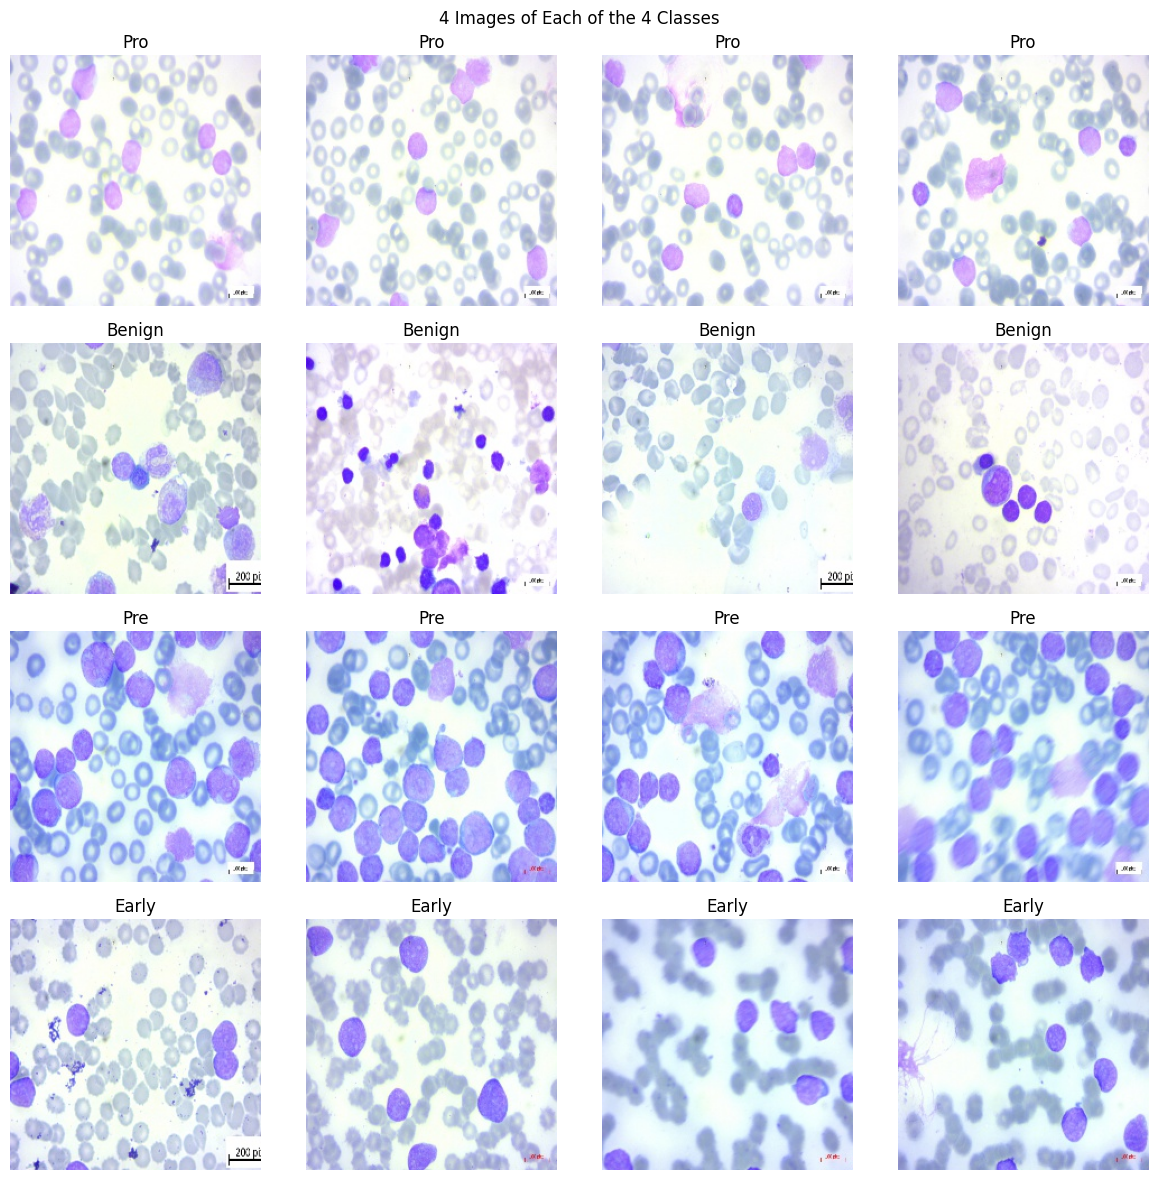

In [4]:
# Create a dictionary to store images by their labels
label_to_images = {}
for img, label in zip(images, labels):
    if label not in label_to_images:
        label_to_images[label] = []
    label_to_images[label].append(img)

# Visualize 4 images of each of the 4 classes
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle('4 Images of Each of the 4 Classes')

for i, (label, imgs) in enumerate(label_to_images.items()):
    for j in range(4):
        axes[i, j].imshow(imgs[j])
        axes[i, j].set_title(label)
        axes[i, j].axis('off')

plt.tight_layout()
plt.show()

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(labels)
np.unique(y)

array([0, 1, 2, 3])

In [11]:
# load the features
features = np.load('embeddings.npy')

## Train a classifier on PCA reduced embeddings

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=10)
features_pca = pca.fit_transform(features)


split the data into train and test sets

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_pca, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2604, 10), (652, 10), (2604,), (652,))

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, f1_score

def plot_metrics(y_true, y_pred, y_score, classes, title='Confusion Matrix and ROC Curve'):
    # Create subplots with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(title, fontsize=16)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    ax1.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax1.set_title('Confusion Matrix')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')
    ax1.set_xticks(np.arange(len(classes)))
    ax1.set_yticks(np.arange(len(classes)))
    ax1.set_xticklabels(classes, rotation=45)
    ax1.set_yticklabels(classes)
    ax1.set_ylim(len(classes) - 0.5, -0.5)

    # Annotating confusion matrix
    for i in range(len(classes)):
        for j in range(len(classes)):
            ax1.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

    # ROC Curve
    n_classes = len(np.unique(y_true))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    colors = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal']

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_score[:, i], pos_label=1)
        roc_auc[i] = auc(fpr[i], tpr[i])
        ax2.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'ROC curve (area = {roc_auc[i]:.2f})')

    ax2.plot([0, 1], [0, 1], 'k--', lw=2)
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.legend(loc="lower right")

    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"F1 Score (Weighted): {f1:.2f}")

    # Show the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # To make room for the suptitle
    plt.show()


### Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=0, max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

accuracy_score = clf.score(X_test, y_test)
accuracy_score

0.9340490797546013

F1 Score (Weighted): 0.93


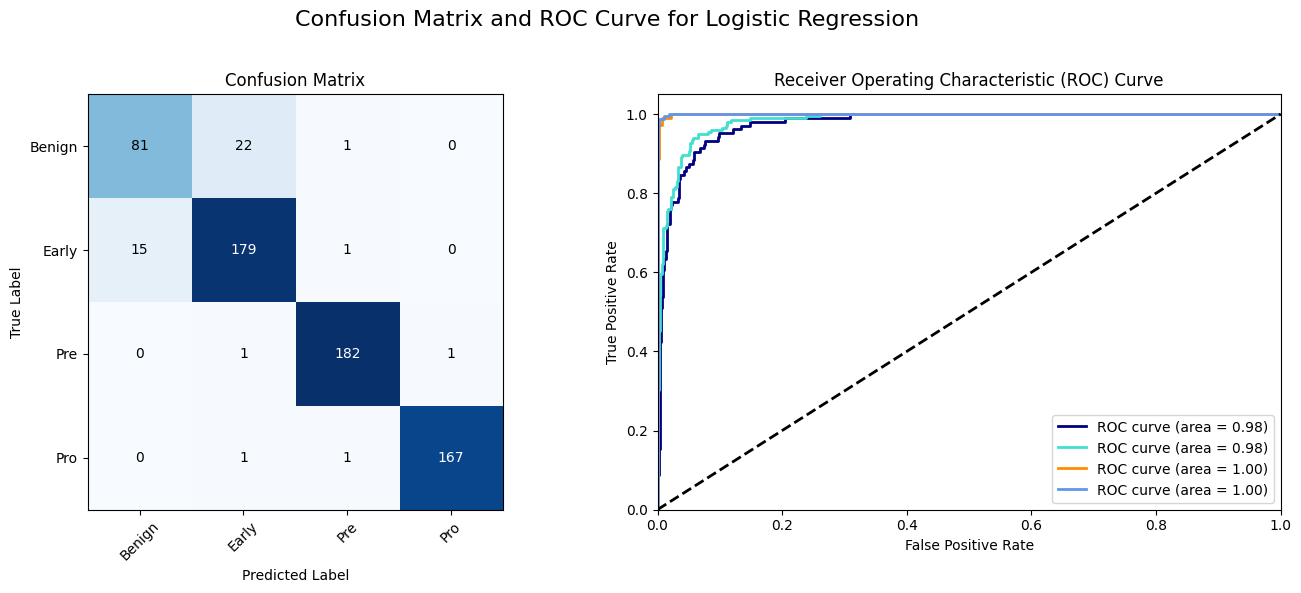

In [17]:
plot_metrics(y_test, y_pred, y_score, le.classes_, title='Confusion Matrix and ROC Curve for Logistic Regression')

### SVM

In [18]:
from sklearn.svm import SVC

clf = SVC(probability=True, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

accuracy_score = clf.score(X_test, y_test)
accuracy_score

0.9616564417177914

F1 Score (Weighted): 0.96


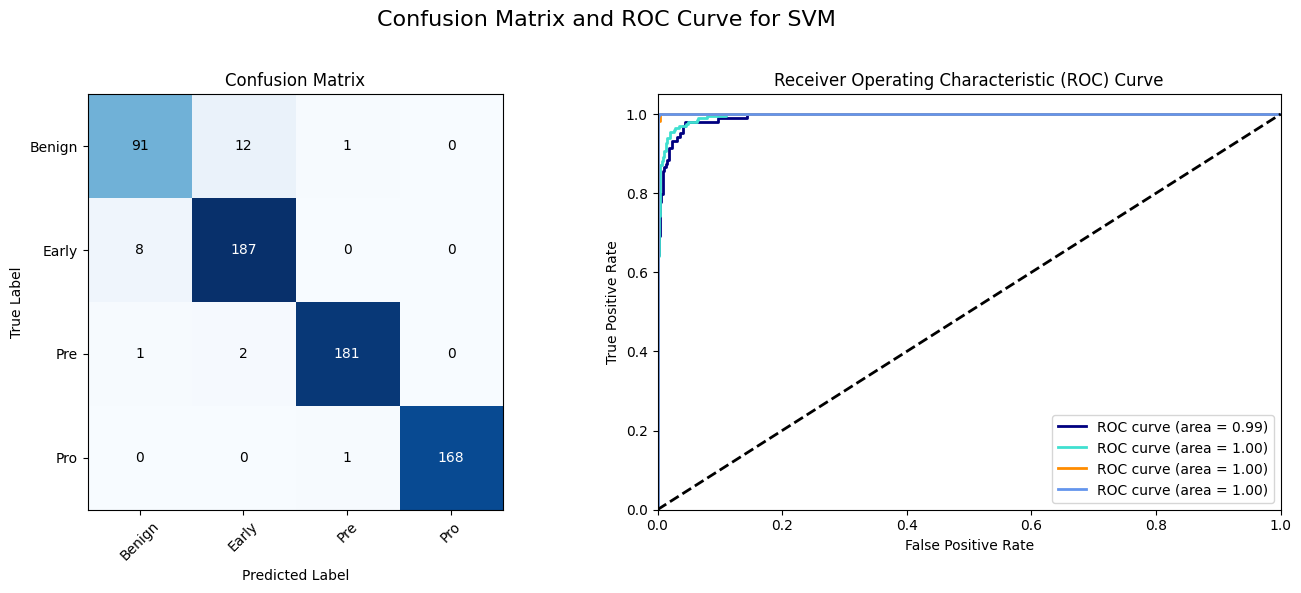

In [19]:
plot_metrics(y_test, y_pred, y_score, le.classes_, title='Confusion Matrix and ROC Curve for SVM')

### Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)

accuracy_score = clf.score(X_test, y_test)
accuracy_score

0.9432515337423313

F1 Score (Weighted): 0.94


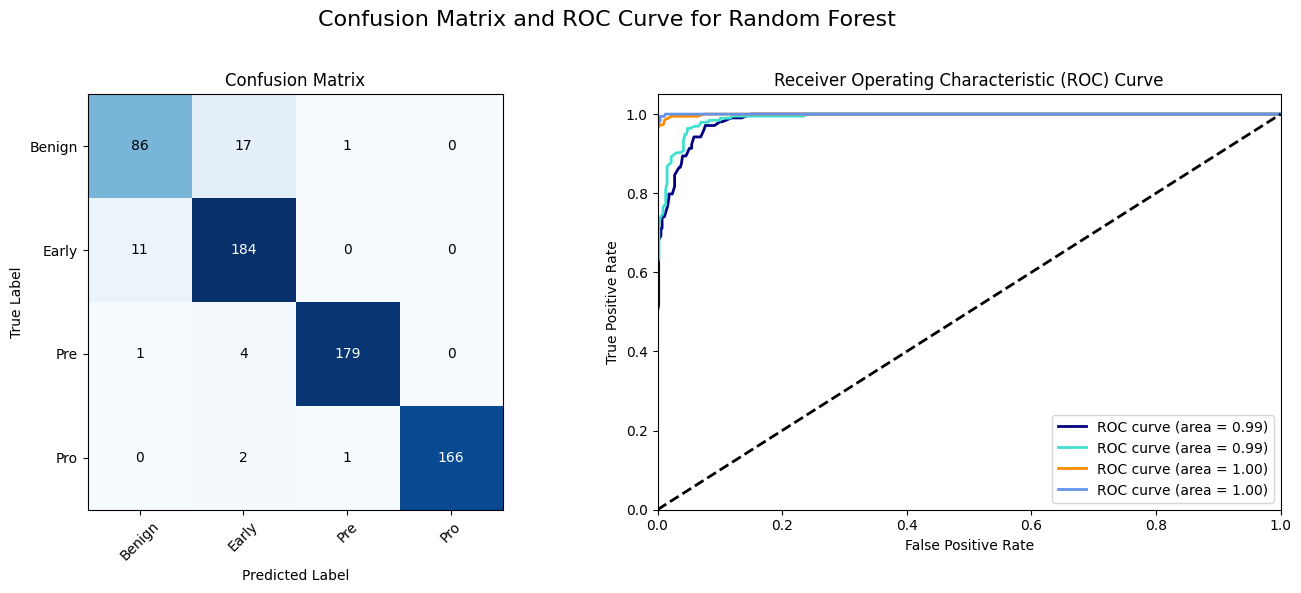

In [21]:
plot_metrics(y_test, y_pred, y_score, le.classes_, title='Confusion Matrix and ROC Curve for Random Forest')